**The following code needs to be run only once. It is for connecting Colab to your Google Drive. When running this cell you will be given a password and you need to enter it here.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**The first thing we have to do is to upload our dataset to Colab. The fastest way to do this is via your Google Drive.**

Steps for uploading a zip file from Google Drive to Colab:
1. Get the id out of the shareable link of the zip file you wish to upload.
You will get a link in this form: 
https://drive.google.com/open?id=1M1S92ZnwuKgFcH7ueUCn_nTNC1SacV3n
Extract the part after "id=".

2. Run the cell below.
Before getting the file, Google will ask you to enter an authentication password, which you can easily get by just following the instructions. You also need to specify the name of the file in the cell.
After entering the password you will have your uploaded zip file in Colab.

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = "1hi5On0ujAfztjtmnC5B8OvhHnk6kQKnk" # Enter the id of the file you want to upload from Google Drive
file_name = "Only_Letters.zip" # Enter the name of the file you want to upload from Google Drive
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(file_name)  

Run this cell to unzip the file.

In [0]:
!unzip "Only_Letters.zip"

**Now we get to the actual application part.**

First we import the needed libraries.

Sklearn is not contained in Colab, so it must be installed first. Run the next cell to do so.

In [0]:
!pip uninstall sklearn -y
!pip install Cython
!pip install https://github.com/Santosh-Gupta/scikit-learn/archive/master.zip

In [6]:
import os
import numpy as np
import cv2 as cv
from sklearn.model_selection import train_test_split
from keras import models, layers, losses, regularizers, callbacks
from sklearn import metrics
import timeit
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


We declare some constant values.

In [0]:
CLASSES = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
           'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
TRAINING_DATA_FOLDER = 'Only_Letters' # Name of the unzipped file, which contains the dataset.
NUMBER_OF_CLASSES = 26
NUMBER_OF_IMAGES = 1815
IMAGE_SIZE_X = 64
IMAGE_SIZE_Y = 64
SPLIT_RATIO = 0.1

**We use the TrainingDataReader class to read images.**

Initially we only read them into the training_data and training_class_labels attributes.
Later, we will divide the data into training and testing data.

An important thing to note about the structure of the dataset folder is that it must have separate folders for each class and the images should be distributed correspondingly. Also, the folder names should be the same az the class name, thus we have a separate folder for each letter of the american alphabet.

In [0]:
class TrainingDataReader:

    def __init__(self):
      """
      attributes:
      training_data: contains data that we will use to train our model
      training_class_labels: actual classes that each training sample belongs to
      testing_data: contains data that we will use to test the accuracy of our trained model
      testing_class_labels: actual classes that each testing sample belongs to
      """
      self.number_of_classes = NUMBER_OF_CLASSES
      self.training_data = np.zeros(shape=(NUMBER_OF_IMAGES, IMAGE_SIZE_X, IMAGE_SIZE_Y, 3), dtype='float32')
      self.training_class_labels = np.zeros(shape=NUMBER_OF_IMAGES, dtype='uint8')
      self.testing_data = None
      self.testing_class_labels = None
      self.counter = 0

    def read_training_data(self):
      """
      Obtains folder with data from the next class and calls 'read_data_for_one_class' to actually read the data
      """
      self.counter = 0
      for category in CLASSES:
          path = os.path.join(TRAINING_DATA_FOLDER, category)
          class_num = CLASSES.index(category)
          self.read_data_for_one_class(path, class_num)

    def read_data_for_one_class(self, path, class_num):
      """
      Main method of this first part of the project.
      This method gets the path to a folder belonging to one class, iterates through the photos, reads them,
      normalizes them and adds them to the training data, as well as the corresponding class labels.
      """
      print('Currently reading data for class number {}...'.format(class_num))
      for image in os.listdir(path):
        try:
          image_array = cv.imread(os.path.join(path, image), cv.IMREAD_COLOR)

          if image_array.size == 0:
            raise FileNotFoundError

          new_array = cv.resize(image_array, (IMAGE_SIZE_X, IMAGE_SIZE_Y))
          self.training_data[self.counter] = cv.normalize(new_array, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
          self.training_class_labels[self.counter] = class_num
          self.counter = self.counter + 1
        except FileNotFoundError as e:
          print(e)
          exit(-1)
    def split_data(self):
      training_data_reader.training_data, training_data_reader.testing_data, \
        training_data_reader.training_class_labels, training_data_reader.testing_class_labels = \
        train_test_split(training_data_reader.training_data, training_data_reader.training_class_labels, test_size = SPLIT_RATIO)          

**Run the next cell in order to read the images and split them into training and testing sets.**

Using sklearn's train_test_split method we will split our original data into training and testing set. It is very important to also note that this method shuffles the data by default. This is something that will be crucial to obtain a high accuracy not only on the training data, but on the validation data as well.

In [0]:
training_data_reader = TrainingDataReader()
training_data_reader.read_training_data()
training_data_reader.split_data()

Run this next cell to save your data in a file called hra_training_data.h5. This is useful if you wish to train your network locally or on another PC and you don't want to read the images every time, you can just load the numpy arrays from the .h5 file. 

In [0]:
import h5py

with h5py.File('hra_training_data.h5', 'w') as hf:
  hf.create_dataset("training_data", data=training_data_reader.training_data)
  hf.create_dataset("training_class_labels", data=training_data_reader.training_class_labels)
  hf.create_dataset("testing_data", data=training_data_reader.testing_data)
  hf.create_dataset("testing_class_labels", data=training_data_reader.testing_class_labels)

Run this cell in order to copy your data to your Google drive (make sure first that you mounted your drive).

After the copying is done, from your Google drive you can save the file locally. 

If you get an error, mounting your drive again (i.e. running the first cell once again) may solve the problem.

In [0]:
!cp hra_training_data.h5 "drive/My Drive/"

**The next class is where all the magic happens: the architecture of the convolutional neural network that we use for training.**

In [0]:
class CNNArchitecture:

    # Declaring model hyper (non-trainable) parameters for training
    INPUT_SHAPE = (64, 64, 3)
    NUMBER_OF_FILTERS_1 = 32
    NUMBER_OF_FILTERS_2 = 64
    NUMBER_OF_FILTERS_3 = 128
    NUMBER_OF_FILTERS_4 = 256
    KERNEL_SIZE = 3
    STRIDES = (1, 1)
    POOL_SIZE = 3
    DROPOUT_RATE = 0.5
    DENSE_UNITS = 512

    # String constants
    PADDING = "same"
    ACTIVATION_FUNCTION = 'relu'
    SECOND_ACTIVATION_FUNCTION = 'softmax'

    # Used regularizer to avoid over-fitting
    KERNEL_REGULARIZER = regularizers.l2(0.001)

    # Hyper parameters for training
    EPOCHS = 6
    BATCH_SIZE = 64
    VALIDATION_SPLIT = 0.1

    def __init__(self):
        self.model = models.Sequential()
        self.history = None

    def build_model(self):
        """
        Method used to build the model what will be used for training.
        Override this method with your own implementation and subclass for trying out a different model.
        """
        self.model.add(layers.Conv2D(filters=self.NUMBER_OF_FILTERS_2, kernel_size=self.KERNEL_SIZE,
                                     strides=self.STRIDES, padding=self.PADDING, activation=self.ACTIVATION_FUNCTION,
                                     input_shape=self.INPUT_SHAPE))
        self.model.add(layers.Conv2D(filters=self.NUMBER_OF_FILTERS_2, kernel_size=self.KERNEL_SIZE,
                                     strides=self.STRIDES, padding=self.PADDING, activation=self.ACTIVATION_FUNCTION))
        self.model.add(layers.MaxPooling2D(pool_size=self.POOL_SIZE))

        self.model.add(layers.Conv2D(filters=self.NUMBER_OF_FILTERS_2, kernel_size=self.KERNEL_SIZE,
                                     strides=self.STRIDES, padding=self.PADDING, activation=self.ACTIVATION_FUNCTION,
                                     input_shape=self.INPUT_SHAPE))
        self.model.add(layers.Conv2D(filters=self.NUMBER_OF_FILTERS_3, kernel_size=self.KERNEL_SIZE,
                                     strides=self.STRIDES, padding=self.PADDING, activation=self.ACTIVATION_FUNCTION))
        self.model.add(layers.MaxPooling2D(pool_size=self.POOL_SIZE))

        self.model.add(layers.Conv2D(filters=self.NUMBER_OF_FILTERS_3, kernel_size=self.KERNEL_SIZE,
                                     strides=self.STRIDES, padding=self.PADDING, activation=self.ACTIVATION_FUNCTION))
        self.model.add(layers.Conv2D(filters=self.NUMBER_OF_FILTERS_4, kernel_size=self.KERNEL_SIZE,
                                     strides=self.STRIDES, padding=self.PADDING, activation=self.ACTIVATION_FUNCTION))
        self.model.add(layers.MaxPooling2D(pool_size=self.POOL_SIZE))

        self.model.add(layers.BatchNormalization())
        self.model.add(layers.Flatten())
        self.model.add(layers.Dropout(rate=self.DROPOUT_RATE))

        self.model.add(
            layers.Dense(self.DENSE_UNITS, activation=self.ACTIVATION_FUNCTION, kernel_regularizer=self.KERNEL_REGULARIZER))
        self.model.add(layers.Dense(NUMBER_OF_CLASSES, activation=self.SECOND_ACTIVATION_FUNCTION))

        print(self.model.summary())

        self.model.compile(optimizer='adam',
                           loss=losses.sparse_categorical_crossentropy,
                           metrics=['accuracy'])

    def train_model(self, train_images, class_labels):
        """
        Method used to train the built model.
        :param train_images: images that the training will be done on
        :param class_labels: classes that the images belong to
        """
        save_weights_callback = self.use_callback_for_saving_model()
        early_stopping_callback = self.use_callback_for_early_stopping()
        self.history = self.model.fit(train_images, class_labels, epochs=self.EPOCHS, batch_size=self.BATCH_SIZE, shuffle=True,
                                      validation_split=self.VALIDATION_SPLIT, callbacks=[save_weights_callback, early_stopping_callback])

        print("Model has been created.")
        self.model.summary()

    def evaluate_model(self, test_images, class_labels):
        """
        Method used to test the built model.
        :param test_images: images that the model will be evaluated on
        :param class_labels: classes that the images belong to
        """
        evaluate_metrics = self.model.evaluate(test_images, class_labels)
        print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1] * 100), "\nEvaluation loss = ",
              "{:.6f}".format(evaluate_metrics[0]))

    @staticmethod
    def use_callback_for_saving_model():
        """
        Create a Callback that saves the model's weights.
        """
        save_weights_callback = callbacks.ModelCheckpoint(filepath=WEIGHTS_PATH, save_weights_only=True, verbose=1)
        return save_weights_callback

    @staticmethod
    def use_callback_for_early_stopping():
      """
      Create a Callback that stops the model earlier if no improvements are made, thus avoid overfitting.
      """
      early_stopping_callback = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=1)
      return early_stopping_callback

    def predict_classes_for_images(self, images):
        """
        Takes an array of images as argument and for each image predicts the class with maximum probability.
        :param images: input images which we need prediction for
        :return: array of predictions for each input image
        """
        predictions = self.model.predict(images)
        max_predictions = []

        for idx in range(len(predictions)):
            max_predictions.append(np.argmax(predictions[idx]))

        return max_predictions

    @staticmethod
    def compute_confusion_matrix(true_labels, predicted_labels):
        confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
        return confusion_matrix

**Run the following cell to train the neural network and to compute the total time for training in seconds.**

You will be able to see the training and validation accuracy, as well as the architecture of the built model. You may need to run this cell a few times in order to get a higher accuracy.

In [0]:
WEIGHTS_PATH = 'weights.ckpt'

cnn_architecture = CNNArchitecture()
cnn_architecture.build_model()

start = timeit.default_timer()
cnn_architecture.train_model(training_data_reader.training_data, training_data_reader.training_class_labels)
stop = timeit.default_timer()

print('Total Run Time for Training: {}'.format(stop - start))

Run the next cell in order to view the evolution of the training and validation accuracy as the epochs go on.

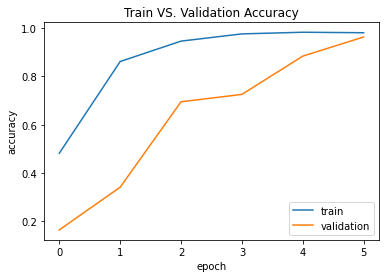

In [27]:
plt.plot(cnn_architecture.history.history['accuracy'])
plt.plot(cnn_architecture.history.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('Train VS. Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Run the next cell in order to view the evolution of the training and validation loss as the epochs go on.

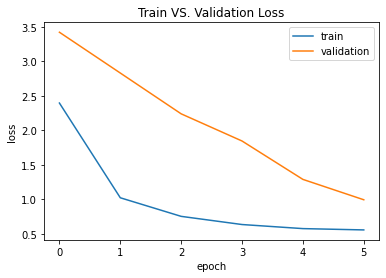

In [31]:
plt.plot(cnn_architecture.history.history['loss'])
plt.plot(cnn_architecture.history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right')
plt.title('Train VS. Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

The following cell will calculate the predicted_classes for the testing images and it will display the confusion matrix.

In [0]:
predicted_labels = cnn_architecture.predict_classes_for_images(training_data_reader.testing_data)
confusion_matrix = cnn_architecture.compute_confusion_matrix(training_data_reader.testing_class_labels, predicted_labels)

df = pd.DataFrame(confusion_matrix, index = [i for i in CLASSES],
                  columns = [i for i in CLASSES])
plt.figure(figsize=(NUMBER_OF_CLASSES, NUMBER_OF_CLASSES))
sn.heatmap(df, annot=True)